In [1]:
import io
import os
import re
import sys
import csv
import gzip
import time
import json
import pickle
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
from scipy.stats import pearsonr
# import sqlite3
# from PIL import Image
import matplotlib.pyplot as plt
# from plotnine import *
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
# from collections import Counter
# import seaborn as sns
# import matplotlib.colors as mcolors
# from matplotlib.ticker import FuncFormatter
import itertools
import collections
import pyreadr
import psa
import pywfa
from IPython.display import display_html, IFrame
# import patchworklib as pw
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus
from lcwgsus.variables import *
from warnings import simplefilter
from hla_phase import *

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.options.mode.chained_assignment = None

# Genuine logics changed from the main script were marked by string **X** in the original R files.
# Simplicity changes were marked by string **Y**

<Figure size 100x100 with 0 Axes>

In [34]:
# For oneKG
gene = 'DRB1'
ipd_gen_file_dir = '/well/band/users/rbx225/recyclable_files/hla_reference_files/alignments/'
hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')

ref_samples = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/oneKG.samples', sep = ' ')
hlatypes = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')
ref_samples_removed = ref_samples[~ref_samples['SAMPLE'].isin(hlatypes['Sample ID'].tolist())]
samples_to_remove = ref_samples_removed['SAMPLE'].tolist()
hlatypes = hlatypes[~hlatypes['Sample ID'].isin(samples_to_remove)].sort_values(by = 'Sample ID').reset_index(drop = True)

phased_vcf = "/well/band/users/rbx225/recyclable_files/ref_panels/oneKG_30x/oneKG.chr6.vcf.gz"
reference_allele_file = '/well/band/users/rbx225/recyclable_files/hla/b38_reference_alleles.tsv'
reference_allele_ary = np.array(lcwgsus.read_tsv_as_lst(reference_allele_file))

# return_dict = phase_hla_on_haplotypes(gene = gene, 
#                             ipd_gen_file_dir = ipd_gen_file_dir, 
#                             hla_gene_information = hla_gene_information,
#                             hlatypes = hlatypes,
#                             phased_vcf = phased_vcf, 
#                             reference_allele_ary = reference_allele_ary, 
#                             strict_snp_filter = True,
#                             read_from_QUILT = False, 
#                             subset_vcf_samples = None,
#                             sample_linker = None)
# hlatypes = return_dict['hlatypes']

# individual = 'NA12878'
# ix = hlatypes.index[hlatypes['Sample ID'] == individual][0]
# display_indices = np.arange(10)
# html = '1KG-DRB1.html'

# res = visualise_phase(gene, ix, hlatypes, return_dict, both_het = True)
# compare_phase(display_indices, res, save_html = True, save_name = html)

# plot_first_step_phase(c)
# plot_last_step_phase(return_dict)

In [35]:
# strand = hla_gene_information[hla_gene_information['Name'] == ('HLA-' + gene)]['Strand'].iloc[0]
# reference_allele = reference_allele_ary[np.char.find(reference_allele_ary, gene) != -1][0]
# nucleotides = ['A', 'T', 'C', 'G']

# ipd_gen_file = ipd_gen_file_dir + gene + '_gen.txt'
# with open(ipd_gen_file, "r") as file:
#     lines = file.readlines()
# gDNA_idx = []
# names = []
# i = 0
# while len(gDNA_idx) < 2:
#     l = lines[i]
#     if 'gDNA' in l:
#         gDNA_idx.append(i)
#     elif l.lstrip(' ').split(' ')[0].startswith(gene + '*'):
#         name = l.lstrip(' ').split(' ')[0]
#         names.append(name)
#     i += 1

# first_base = int(lines[gDNA_idx[0]].split(' ')[-1].split('\n')[0])
# n_alleles = gDNA_idx[1] - gDNA_idx[0] - 3

# alleles_dict = {k:'' for k in names}
# for i, s in enumerate(lines):
#     r = s.lstrip(' ')
#     if r.startswith(gene):
#         r = r.rstrip(' \n')
#         name = r.split(' ')[0]
#         sequence = r.split(' ')[1:]
#         sequence = ''.join(sequence)
#         alleles_dict[name] = alleles_dict[name] + sequence

# db = pd.DataFrame({key: list(value) for key, value in alleles_dict.items()}).T
# db = db.drop(columns=db.columns[db.eq('|').all()])
# db.columns = range(db.shape[1])

# length = len(db.columns)
# positions = [first_base]*length

# db.loc[len(db)] = positions

# r_idx = len(db) - 1
# for i in db.columns[1:]:
#     if db.iloc[0, i] == '.':
#         db.iloc[r_idx, i] = db.iloc[r_idx, i-1]
#     else:
#         if db.iloc[r_idx, i-1] != -1:
#             db.iloc[r_idx, i] = db.iloc[r_idx, i-1] + 1
#         else:
#             db.iloc[r_idx, i] = db.iloc[r_idx, i-1] + 2 # No zero in position. ATG is encoded by 1.
# db.columns = db.iloc[r_idx]
# db = db.iloc[:r_idx]

# db = db.loc[:,db.columns >= 0] # Trims genomes before CDS, is this really necessary?
# db = db.apply(lambda c: c.replace('-', c[0]) ,axis = 0)

# if strand != 1:
#     db.replace({'A': 't', 'C': 'g', 'G': 'c', 'T': 'a'}, inplace=True)
#     db.replace({'a': 'A', 'c': 'C', 'g': 'G', 't': 'T'}, inplace=True)
#     db = db.iloc[:, ::-1]
# db.columns = range(db.shape[1])

# counts = db.loc[reference_allele,:].value_counts()
# aligned_bases = counts[counts.index.isin(nucleotides)].sum()

# if strand == 1:
#     genome_pos =  hla_gene_information[hla_gene_information['Name'] == ('HLA-' + gene)]['Start'].iloc[0]
#     start = genome_pos
# else:
#     genome_pos =  hla_gene_information[hla_gene_information['Name'] == ('HLA-' + gene)]['End'].iloc[0]
#     start = genome_pos - aligned_bases + 1
# end = start + aligned_bases - 1

# full_start = start
# full_end = end

# allele_pos = [start]*db.shape[1]
# for i, n in enumerate(db.loc[reference_allele,:].values[1:], start = 1):
#     if n in nucleotides:
#         allele_pos[i] = allele_pos[i - 1] + 1
#     else:
#         allele_pos[i] = allele_pos[i - 1]

# # ourpos -> allele_pos
# # first_row = ourrow is the index in db of the referece allele

# variants_df = []
# for i in range(len(db)):
#     variants_df.append(extract_snps_from_row(db.loc[reference_allele,:], db.iloc[i,], allele_pos))
# vcf = pd.concat(variants_df).drop_duplicates()
# vcf = vcf[(vcf['ref'].isin(nucleotides)) & (vcf['alt'].isin(nucleotides))].sort_values(by = 'pos').reset_index(drop = True)

# allele_pos = np.array(allele_pos)
# dbcopy = pd.DataFrame()
# aligned_df = pd.DataFrame()
# variants_to_remove = []

# for i in range(vcf.shape[0]):
#     pos, a1, a2 = vcf.iloc[i, :3]
#     index = np.where((allele_pos == pos))[0]

#     if len(index) == 1:
#         index = index[0]
#         dbcopy[dbcopy.shape[1]] = db[index]        
#         aligned_df[aligned_df.shape[1]] = db[index].apply(recode_variant, args = (a2))
#     else:
#         variants_to_remove.append(i)

# vcf = vcf[~vcf.index.isin(variants_to_remove)].reset_index(drop = True) 
# # This is a remedy when extract_snps_from_row fails to detect insertions. 
# # For DRB1 we get 2442 variants instead of 2452, fairly good I'd say
# dbfull = db
# db = dbcopy

# sample = pd.DataFrame({
#     "ID_1": aligned_df.index,
#     "ID_2": aligned_df.index,
#     "missing": 0
# })
# vcf['id'] = 'chr6:' + vcf['pos'].astype(str)
# haps = aligned_df.T
# cond = (haps == -1).mean(axis=1) < 0.1
# haps = haps[cond].reset_index(drop = True)
# vcf = vcf[cond].reset_index(drop = True)

# start = vcf.loc[0, 'pos']
# end =vcf.loc[len(vcf) - 1, 'pos']

# cond = (allele_pos >= start) & (allele_pos <= end)
# allele_pos = allele_pos[cond]
# dbfull = dbfull.iloc[:, np.where(cond == True)[0]]
# dbfull.columns = range(dbfull.shape[1])

# # Imputing database alleles
# for i, a in enumerate(haps.columns):
#     haps_undetermined = haps[a] == -1

#     allele_col = haps[~haps_undetermined][a]
#     subseted_db =  haps[~haps_undetermined] 
#     pairwise_distance = subseted_db.sub(subseted_db[a], axis=0)
#     counts = pairwise_distance.abs().sum().sort_values().iloc[1:]
#     closest_allele_idx = 0
#     substituted_nucleotides = np.array([np.nan]*np.sum(haps_undetermined))
#     substituted_indices = haps_undetermined[haps_undetermined == True].index

#     while np.isnan(substituted_nucleotides).any() > 0:
#         closest_allele = counts.index[closest_allele_idx]

#         target_haplotype = haps.loc[substituted_indices, closest_allele]
#         substitutable = target_haplotype[target_haplotype.values != -1]
#         substituted_nucleotides[np.where(np.in1d(substituted_indices, substitutable.index))[0]] = substitutable.values
#         closest_allele_idx += 1

#     haps.loc[substituted_indices, a] = substituted_nucleotides
#     # haps has dim n_variants * n_alleles

# prepared_vcf = vcf
# alleles = db.index
# prepared_vcf['pos']  = prepared_vcf['pos'].astype(int)

# variant_alleles = haps

# positions = vcf['pos'].astype(float).values
# zz = np.zeros(haps.shape[0]) 
# for i in range(len(zz)):
#     zz[i] = np.sum(allele_pos == positions[i])
# zz3 = np.zeros_like(zz)
# for i in range(len(zz3)):
#     zz3[i] = np.sum(positions == positions[i])
# filter_conditions = (zz3 == 1) & (zz == 1)

# snpinfo = prepared_vcf.loc[filter_conditions, :].reset_index(drop = True)
# snpinfo = snpinfo.iloc[:,[3, 0, 1, 2]]
# variant_alleles = variant_alleles.loc[filter_conditions, :]
# haps = variant_alleles.copy().reset_index(drop = True)
# # haps is `n_variant \times n_alleles` df, with each entry as 0/1 representing ref/alt from the fake vcf "prepared_vcf"

# start = snpinfo['pos'].values[0]
# end = snpinfo['pos'].values[-1]

# snp_haps = read_vcf(
#     full_start - 1000, 
#     full_end + 1000, 
#     phased_vcf, 
#     hlatypes)

# retained_samples = snp_haps.columns[4:].tolist()
# hlatypes = hlatypes[hlatypes['Sample ID'].isin(retained_samples)].reset_index(drop = True)

In [61]:
hrcfirstalleles = snp_haps[['snp', 'pos', 'ref', 'alt']]
hrcsecondalleles = snp_haps[['snp', 'pos', 'ref', 'alt']]
for s in retained_samples:
    hrcfirstalleles[s] = snp_haps[s].str.split('|').str.get(0).astype(int)
    hrcsecondalleles[s] = snp_haps[s].str.split('|').str.get(1).astype(int)

hrcfirstalleles_tmp = hrcfirstalleles[(hrcfirstalleles['pos'] >= start) & (hrcfirstalleles['pos'] <= end)]
hrcsecondalleles_tmp = hrcsecondalleles[(hrcsecondalleles['pos'] >= start) & (hrcsecondalleles['pos'] <= end)]
hrcfirstalleles_full = hrcfirstalleles.copy()
hrcsecondalleles_full = hrcsecondalleles.copy()
hrcfirstalleles = hrcfirstalleles_tmp
hrcsecondalleles = hrcsecondalleles_tmp    

original_variants = (snpinfo['pos'].astype(str) + snpinfo['ref'] + snpinfo['alt']).values
flipped_variants = (snpinfo['pos'].astype(str) + snpinfo['alt'] + snpinfo['ref']).values

def subset_snp_haps(hrcfirstalleles, original_variants = original_variants, flipped_variants = flipped_variants):    
    hrcfirstalleles_original = hrcfirstalleles[hrcfirstalleles['snp'].isin(original_variants)]
    hrcfirstalleles_flipped = hrcfirstalleles[hrcfirstalleles['snp'].isin(flipped_variants)]
    if len(hrcfirstalleles_flipped) == 0:
        hrcfirstalleles = hrcfirstalleles_original.drop(columns = ['snp', 'pos', 'ref', 'alt']).reset_index(drop = True)
    elif len(hrcfirstalleles_flipped) == 1:
        hrcfirstalleles_flipped.loc[:, retained_samples] = 1 - hrcfirstalleles_flipped.loc[:, retained_samples]
        hrcfirstalleles = pd.concat([hrcfirstalleles_original, hrcfirstalleles_flipped.to_frame().T], axis = 0).sort_index()
    else:
        hrcfirstalleles_flipped.loc[:, retained_samples] = 1 - hrcfirstalleles_flipped.loc[:, retained_samples]
        hrcfirstalleles = pd.concat([hrcfirstalleles_original, hrcfirstalleles_flipped]).sort_index()
    hrcfirstalleles = hrcfirstalleles.sort_index().reset_index(drop = True)
    hrcfirstalleles.columns = range(hrcfirstalleles.shape[1])
    return hrcfirstalleles.T

hrcfirstalleles = subset_snp_haps(hrcfirstalleles)
hrcsecondalleles = subset_snp_haps(hrcsecondalleles)
hrcfirstalleles

,0,1,2,3,4,5,6,7,8,9,...,370,371,372,373,374,375,376,377,378,379
0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2563,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2565,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
2566,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [173]:
ixs = [29,598,600,721,1027,1168,1506,1677,1853,1880,2072,2516]
ix = 2072
name = 'NA19077'
oldphase1[ixs]

array([ 57.06666667,  77.        , 118.        ,  58.        ,
        50.81818182,  55.        ,  61.02564103,  61.        ,
        60.18181818,  56.8       ,  54.18181818,  52.        ])

In [172]:
oldphase2[ixs]

array([50.93333333, 57.        , 62.        , 52.        , 73.18181818,
       69.        , 59.02564103, 53.        , 58.18181818, 65.2       ,
       54.18181818, 64.        ])

In [168]:
# valid_corr_indices = np.where(~np.isnan(corr))[0]
valid_corr_indices = np.where((~np.isnan(corr)) & (corr > 0.8))[0]

dist11 = phase_subtraction(hrcfirstalleles, predfirstalleles, valid_corr_indices)
dist12 = phase_subtraction(hrcfirstalleles, predsecondalleles, valid_corr_indices)
dist21 = phase_subtraction(hrcsecondalleles, predfirstalleles, valid_corr_indices)
dist22 = phase_subtraction(hrcsecondalleles, predsecondalleles, valid_corr_indices)

phase1 = dist11 + dist22
phase2 = dist12 + dist21

d11 = dist11
d21 = dist21
d12 = dist12
d22 = dist22

phased1 = (
    (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 < 4) & (phase2 > 4)) |
    (~np.isnan(phase1) & ~np.isnan(phase2) & (phase2 - phase1 > 2) & (phase1 < 4)) |
    ((reftypes1 != 'nan') & (reftypes2 != 'nan') & (reftypes1 == reftypes2)) |
    (np.isnan(d21) & ~np.isnan(d12) & (d12 - d22 > 2) & (d22 < 2)) |
    (np.isnan(d12) & ~np.isnan(d21) & (d21 - d11 > 2) & (d11 < 2))
)

phased2 = (
    (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 > 4) & (phase2 < 4)) |
    (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 - phase2 > 2) & (phase2 < 4)) |
    (np.isnan(d21) & ~np.isnan(d12) & (d22 - d12 > 2) & (d12 < 2)) |
    (np.isnan(d12) & ~np.isnan(d21) & (d11 - d21 > 2) & (d21 < 2))
)

phased1old = phased1.copy()
phased2old = phased2.copy()
oldphase1 = phase1.copy()
oldphase2 = phase2.copy()

In [175]:
h1 = hrcfirstalleles.loc[ix,].values
h2 = hrcsecondalleles.loc[ix,].values
p1 = predfirstalleles[ix,]
p2 = predsecondalleles[ix,]

In [176]:
np.where((h1[valid_corr_indices]-p1[valid_corr_indices]) != 0)[0]

array([  0,   1,   2,   3,   4,   7,   9,  12,  15,  17,  19,  23,  24,
        58,  60,  62,  65,  66,  67,  70,  81,  91,  92,  94, 102, 117,
       118, 119, 129])

In [177]:
np.where((h2[valid_corr_indices]-p2[valid_corr_indices]) != 0)[0]

array([  7,   9,  12,  15,  17,  19,  37,  38,  58,  60,  62,  65,  66,
        67,  70,  76,  77,  79,  81,  91,  92,  94, 102, 105, 127, 129])

In [178]:
np.where((h1[valid_corr_indices]-p2[valid_corr_indices]) != 0)[0]

array([ 25,  26,  27,  30,  31,  34,  36,  40,  42,  43,  44,  45,  47,
        48,  49,  50,  51,  52,  53,  76,  77,  79, 127])

In [179]:
np.where((h2[valid_corr_indices]-p1[valid_corr_indices]) != 0)[0]

array([  0,   1,   2,   3,   4,  23,  24,  25,  26,  27,  30,  31,  34,
        36,  37,  38,  40,  42,  43,  44,  45,  47,  48,  49,  50,  51,
        52,  53, 105, 117, 118, 119])

In [189]:
suspicious_idx = [0,   1,   2,   3,   4, 23,  24, 117]

Xsidx = valid_corr_indices[suspicious_idx]
Xs = np.array(Xsidx)
Xspos = merged_snps.loc[Xs,:]['pos'].tolist()
Xsposb38 = np.where(np.in1d(allele_pos, Xspos))[0]
tmp = dbfull.loc[:, Xsposb38]
tmp = tmp[tmp.index.str.startswith('DRB1*09:01') | tmp.index.str.startswith('DRB1*10:01')]
tmp

,4,122,133,235,245,2018,2030,11137
DRB1*09:01:02:01,A,G,G,A,A,C,A,C
DRB1*09:01:02:02,A,G,G,A,A,C,A,C
DRB1*09:01:02:03,A,G,G,A,A,C,A,C
DRB1*09:01:02:04,A,G,G,A,A,C,A,C
DRB1*09:01:02:05,A,G,G,A,A,C,A,C
DRB1*09:01:02:06,A,G,G,A,A,C,A,C
DRB1*09:01:02:07,A,G,G,A,A,C,A,C
DRB1*09:01:02:08,A,G,G,A,A,C,A,C
DRB1*09:01:02:09,A,G,G,A,A,C,A,C
DRB1*09:01:02:10,A,G,G,A,A,C,A,C


In [190]:
merged_snps.loc[Xs,:]

,pos,ref,alt,id
0,32579059,A,T,chr6:32579059
3,32579175,G,A,chr6:32579175
4,32579186,G,A,chr6:32579186
5,32579286,A,G,chr6:32579286
6,32579296,A,G,chr6:32579296
43,32581024,C,T,chr6:32581024
44,32581036,A,G,chr6:32581036
282,32586106,T,C,chr6:32586106


In [192]:
','.join([f'chr6:{i}' for i in allele_pos[Xsposb38]])

'chr6:32579059,chr6:32579175,chr6:32579186,chr6:32579286,chr6:32579296,chr6:32581024,chr6:32581036,chr6:32586106'

In [41]:
hrcfirstalleles = snp_haps[['snp', 'pos', 'ref', 'alt']]
hrcsecondalleles = snp_haps[['snp', 'pos', 'ref', 'alt']]
for s in retained_samples:
    hrcfirstalleles[s] = snp_haps[s].str.split('|').str.get(0).astype(int)
    hrcsecondalleles[s] = snp_haps[s].str.split('|').str.get(1).astype(int)

hrcfirstalleles_tmp = hrcfirstalleles[(hrcfirstalleles['pos'] >= start) & (hrcfirstalleles['pos'] <= end)]
hrcsecondalleles_tmp = hrcsecondalleles[(hrcsecondalleles['pos'] >= start) & (hrcsecondalleles['pos'] <= end)]
hrcfirstalleles_full = hrcfirstalleles.copy()
hrcsecondalleles_full = hrcsecondalleles.copy()
hrcfirstalleles = hrcfirstalleles_tmp
hrcsecondalleles = hrcsecondalleles_tmp    

original_variants = (snpinfo['pos'].astype(str) + snpinfo['ref'] + snpinfo['alt']).values
flipped_variants = (snpinfo['pos'].astype(str) + snpinfo['alt'] + snpinfo['ref']).values

def subset_snp_haps(hrcfirstalleles, original_variants = original_variants, flipped_variants = flipped_variants):    
    hrcfirstalleles_original = hrcfirstalleles[hrcfirstalleles['snp'].isin(original_variants)]
    hrcfirstalleles_flipped = hrcfirstalleles[hrcfirstalleles['snp'].isin(flipped_variants)]
    if len(hrcfirstalleles_flipped) == 0:
        hrcfirstalleles = hrcfirstalleles_original.drop(columns = ['snp', 'pos', 'ref', 'alt']).reset_index(drop = True)
    elif len(hrcfirstalleles_flipped) == 1:
        hrcfirstalleles_flipped.loc[:, retained_samples] = 1 - hrcfirstalleles_flipped.loc[:, retained_samples]
        hrcfirstalleles = pd.concat([hrcfirstalleles_original, hrcfirstalleles_flipped.to_frame().T], axis = 0).sort_index()
    else:
        hrcfirstalleles_flipped.loc[:, retained_samples] = 1 - hrcfirstalleles_flipped.loc[:, retained_samples]
        hrcfirstalleles = pd.concat([hrcfirstalleles_original, hrcfirstalleles_flipped]).sort_index()
    hrcfirstalleles = hrcfirstalleles.sort_index().reset_index(drop = True)
    hrcfirstalleles.columns = range(hrcfirstalleles.shape[1])
    return hrcfirstalleles.T

hrcfirstalleles = subset_snp_haps(hrcfirstalleles)
hrcsecondalleles = subset_snp_haps(hrcsecondalleles)

samples = np.array(alleles).reshape(-1, 1)
c1 = [s[0].split('*') for s in samples]
vv = np.empty((samples.shape[0], 3), dtype=object)
ww = [c[1] for c in c1]
for i in range(len(c1)):
    vv[i, 0] = c1[i][0]
c1 = [w.split(':') for w in ww]
for i in range(len(c1)):
    vv[i, 1] = c1[i][0]
    vv[i, 2] = c1[i][1]
fourdigit = [f"{vv[i, 1]}:{vv[i, 2]}" for i in range(len(vv))]
ufourdigit = np.unique(fourdigit)
# Convert reference alleles to 4-digit resolution. vv and ww are just intermediate variables of no use
# ufourdigit is unique 4-digit alleles

haps = np.array(haps, dtype=float)
newhaps = np.empty((haps.shape[0], len(ufourdigit)))
for i in range(newhaps.shape[1]):
    tt = np.where(np.array(fourdigit) == ufourdigit[i])[0]
    if len(tt) < 2:
        tt = np.concatenate((tt, tt))
    newhaps[:, i] = np.mean(haps[:, tt], axis=1)
newhaps = pd.DataFrame(newhaps, columns = ufourdigit)

cols = snpinfo.columns.tolist()
full_vcf = snp_haps.copy()[cols[1:]]
same = pd.merge(full_vcf, snpinfo, on = cols[1:], how = 'inner')
newhaps_original = newhaps.loc[snpinfo[snpinfo['id'].isin(same['id'].values)].index,:]

snpinfo_flipped = snpinfo.iloc[:,[0, 1, 3, 2]]
snpinfo_flipped.columns = cols
flipped = pd.merge(full_vcf, snpinfo_flipped, on = cols[1:], how = 'inner')
newhaps_flipped = 1 - newhaps.loc[snpinfo_flipped[snpinfo_flipped['id'].isin(flipped['id'].values)].index,:]

merged_snps = pd.concat([same, flipped]).sort_values(by = 'pos', ascending = True).reset_index(drop = True)

if len(newhaps_flipped) == 0:
    newhaps = newhaps_original
elif len(newhaps_flipped) == 1:
    newhaps = pd.concat([newhaps_original, newhaps_flipped.to_frame().T], axis = 0).sort_index()
else:
    newhaps = pd.concat([newhaps_original, newhaps_flipped]).sort_index()
newhaps2 = newhaps.reset_index(drop = True)

region_pattern = f"HLA.{gene}."
cols = [i for i, col in enumerate(hlatypes.columns) if re.search(region_pattern, col)]

reftypes1 = hlatypes.iloc[:, cols[0]].astype(str).tolist()
reftypes1 = [re.sub(r"\*", "", t) for t in reftypes1]
reftypes1 = np.array(reftypes1)
reftypes2 = hlatypes.iloc[:, cols[1]].astype(str).tolist()
reftypes2 = [re.sub(r"\*", "", t) for t in reftypes2]
reftypes2 = np.array(reftypes2)

def get_pred_alleles(reftype, newhaps2 = newhaps2):
    predalleles = np.array(pd.DataFrame(np.nan, index=range(len(reftype)), columns=range(newhaps2.shape[0])))
    for i, a in enumerate(reftype):
        if (a == '-9') or (a == 'nan'):
            pass
        elif '/' not in a:
            if a in newhaps2.columns:
                predalleles[i, :] = newhaps2.loc[:, a].T
            else:
                pass
        else:
            valid_alleles = []
            for j in a.split('/'):
                if ':' not in j:
                    onefield = a.split('/')[0].split(':')[0]
                    j = onefield + ':' + j
                if j in newhaps2.columns:
                    valid_alleles.append(j)
            if len(valid_alleles) == 0:
                pass
            else:
                predalleles[i, :] = newhaps2.loc[:, valid_alleles].mean(axis = 1).values
    return predalleles

predfirstalleles = get_pred_alleles(reftypes1)
predsecondalleles = get_pred_alleles(reftypes2)

obsgen = hrcfirstalleles + hrcsecondalleles
predgen = pd.DataFrame(predfirstalleles + predsecondalleles)
corr = np.empty(obsgen.shape[1])
for i in range(obsgen.shape[1]):
    with np.errstate(invalid='ignore'):
        corr[i] = obsgen.loc[:, i].corr(predgen.loc[:, i])

strict_snp_filter = True
if strict_snp_filter:
    valid_corr_indices = np.where((~np.isnan(corr)) & (corr > 0.8))[0]
else:
    valid_corr_indices = np.where(~np.isnan(corr))[0]

dist11 = phase_subtraction(hrcfirstalleles, predfirstalleles, valid_corr_indices)
dist12 = phase_subtraction(hrcfirstalleles, predsecondalleles, valid_corr_indices)
dist21 = phase_subtraction(hrcsecondalleles, predfirstalleles, valid_corr_indices)
dist22 = phase_subtraction(hrcsecondalleles, predsecondalleles, valid_corr_indices)

phase1 = dist11 + dist22
phase2 = dist12 + dist21

d11 = dist11
d21 = dist21
d12 = dist12
d22 = dist22

if strict_snp_filter:
    phased1 = (
        (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 < 4) & (phase2 > 4)) |
        (~np.isnan(phase1) & ~np.isnan(phase2) & (phase2 - phase1 > 2) & (phase1 < 4)) |
        ((reftypes1 != 'nan') & (reftypes2 != 'nan') & (reftypes1 == reftypes2)) |
        (np.isnan(d21) & ~np.isnan(d12) & (d12 - d22 > 2) & (d22 < 2)) |
        (np.isnan(d12) & ~np.isnan(d21) & (d21 - d11 > 2) & (d11 < 2))
    )

    phased2 = (
        (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 > 4) & (phase2 < 4)) |
        (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 - phase2 > 2) & (phase2 < 4)) |
        (np.isnan(d21) & ~np.isnan(d12) & (d22 - d12 > 2) & (d12 < 2)) |
        (np.isnan(d12) & ~np.isnan(d21) & (d11 - d21 > 2) & (d21 < 2))
    )
else:
    phased1 = (
        (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 < 4) & (phase2 > 4)) |
        (~np.isnan(phase1) & ~np.isnan(phase2) & (phase2 - phase1 >= 5)) |
        ((reftypes1 != 'nan') & (reftypes2 != 'nan') & (reftypes1 == reftypes2)) |
        (np.isnan(d21) & ~np.isnan(d12) & (d12 - d22 > 2)) |
        (np.isnan(d12) & ~np.isnan(d21) & (d21 - d11 > 2))
    )

    phased2 = (
        (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 > 4) & (phase2 < 4)) |
        (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 - phase2 >= 5)) |
        (np.isnan(d21) & ~np.isnan(d12) & (d22 - d12 > 2)) |
        (np.isnan(d12) & ~np.isnan(d21) & (d11 - d21 > 2))
    )

phased1old = phased1.copy()
phased2old = phased2.copy()
oldphase1 = phase1.copy()
oldphase2 = phase2.copy()

return_dict = {
    'b38_start': full_start,
    'b38_end': full_end,
    'hlatypes': hlatypes,
    'initial_phase_res': (oldphase1, oldphase2, phased1old, phased2old),
    'merged_snps': merged_snps,
    'db_hap1': predfirstalleles,
    'db_hap2': predsecondalleles,
    'vcf_hap1': hrcfirstalleles,
    'vcf_hap2': hrcsecondalleles
}

phase_df = pd.DataFrame({'Sample': hlatypes['Sample ID'].values, 'first_step_phase1': phased1, 'first_step_phase2': phased2})

for extension in range(50, 101, 50):
    if np.sum(~(phased1 | phased2)) == 0:
        break

    allele1 = np.where(phased1, reftypes1, np.where(phased2, reftypes2, 'None'))
    allele1[np.where(allele1 == '-9')[0]] = 'None'
    allele2 = np.where(phased1, reftypes2, np.where(phased2, reftypes1, 'None'))
    allele2[np.where(allele2 == '-9')[0]] = 'None'

    all_haplotypes = np.append(allele1, allele2)
    nameset = np.unique(all_haplotypes[all_haplotypes != 'None'])

    newstart = start - extension
    newend = end + extension

    hrcfirstalleles = hrcfirstalleles_full[(hrcfirstalleles_full['pos'] >= newstart) & (hrcfirstalleles_full['pos'] <= newend)].drop(columns = ['snp', 'pos', 'ref', 'alt']).reset_index(drop = True).T
    hrcsecondalleles = hrcsecondalleles_full[(hrcsecondalleles_full['pos'] >= newstart) & (hrcsecondalleles_full['pos'] <= newend)].drop(columns = ['snp', 'pos', 'ref', 'alt']).reset_index(drop = True).T
    hrcalleles = pd.concat([hrcfirstalleles, hrcsecondalleles])

    predmat = np.zeros((len(nameset), hrcalleles.shape[1]))
    for i, name in enumerate(nameset):
        predmat[i, :] = np.mean(hrcalleles.iloc[all_haplotypes == name, :], axis=0)
    predmatallele1 = np.full((len(reftypes1), hrcalleles.shape[1]), np.nan)
    predmatallele2 = np.full((len(reftypes1), hrcalleles.shape[1]), np.nan)

    for i in range(len(reftypes1)):
        if reftypes1[i] in nameset: 
            predmatallele1[i, :] = predmat[np.where(nameset == reftypes1[i])[0][0], :]
        if reftypes2[i] in nameset: 
            predmatallele2[i, :] = predmat[np.where(nameset == reftypes2[i])[0][0], :]

    dist11 = np.sum(np.abs(hrcfirstalleles - predmatallele1) > 0.9, axis=1)
    dist12 = np.sum(np.abs(hrcfirstalleles - predmatallele2) > 0.9, axis=1)
    dist21 = np.sum(np.abs(hrcsecondalleles - predmatallele1) > 0.9, axis=1)
    dist22 = np.sum(np.abs(hrcsecondalleles - predmatallele2) > 0.9, axis=1)

    phase1b = dist11 + dist22
    phase2b = dist12 + dist21

    d11 = dist11
    d21 = dist21
    d12 = dist12
    d22 = dist22

    phased1b = (
        (~np.isnan(phase1b) & ~np.isnan(phase2b) & (phase1b < phase2b)) |
        ((reftypes1 != 'nan') & (reftypes2 != 'nan') & (reftypes1 == reftypes2)) |
        (np.isnan(d21) & ~np.isnan(d12) & (d12 - d22 > 2)) |
        (np.isnan(d12) & ~np.isnan(d21) & (d21 - d11 > 2))
    )

    phased2b = (
        (~np.isnan(phase1b) & ~np.isnan(phase2b) & (phase1b > phase2b)) |
        (np.isnan(d21) & ~np.isnan(d12) & (d22 - d12 > 2)) |
        (np.isnan(d12) & ~np.isnan(d21) & (d11 - d21 > 2))
    )

    update = ~phased1 & ~phased2
    phased1[update] = phased1b[update]
    phased2[update] = phased2b[update]

phase_df['final_step_phase1'] = phased1
phase_df['final_step_phase2'] = phased2

phase_df['allele1'] = 'N/A'
phase_df['allele2'] = 'N/A'

for i in range(len(phase_df)):
    p1, p2 = phase_df.loc[i, ['final_step_phase1', 'final_step_phase2']]
    if (not p1) and p2:
        phase_df.loc[i, 'allele1'] = reftypes2[i]
        phase_df.loc[i, 'allele2'] = reftypes1[i]
    elif (not p2) and p1:
        phase_df.loc[i, 'allele1'] = reftypes1[i]
        phase_df.loc[i, 'allele2'] = reftypes2[i]
    else:
        phase_df.loc[i, 'allele1'] = 'N/A'
        phase_df.loc[i, 'allele2'] = 'N/A'

return_dict['phase_df'] = phase_df

unphased_indices = phase_df.index[~(phase_df['final_step_phase1'] | phase_df['final_step_phase2'])]
unphased_df = pd.DataFrame({
    'phase1': oldphase1[unphased_indices],
    'phase2': oldphase2[unphased_indices],
    'type1': reftypes1[unphased_indices],
    'type2': reftypes2[unphased_indices]
})
return_dict['unphased_df'] = unphased_df

In [2]:
# For oneKG
gene = 'B'
ipd_gen_file_dir = '/well/band/users/rbx225/recyclable_files/hla_reference_files/alignments/'
hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')

ref_samples = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/oneKG.samples', sep = ' ')
hlatypes = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')
ref_samples_removed = ref_samples[~ref_samples['SAMPLE'].isin(hlatypes['Sample ID'].tolist())]
samples_to_remove = ref_samples_removed['SAMPLE'].tolist()
hlatypes = hlatypes[~hlatypes['Sample ID'].isin(samples_to_remove)].sort_values(by = 'Sample ID').reset_index(drop = True)

phased_vcf = "/well/band/users/rbx225/recyclable_files/ref_panels/oneKG/oneKG.chr6.vcf.gz"
reference_allele_file = '/well/band/users/rbx225/recyclable_files/hla/b38_reference_alleles.tsv'
reference_allele_ary = np.array(lcwgsus.read_tsv_as_lst(reference_allele_file))

return_dict = phase_hla_on_haplotypes(gene = gene, 
                            ipd_gen_file_dir = ipd_gen_file_dir, 
                            hla_gene_information = hla_gene_information,
                            hlatypes = hlatypes,
                            phased_vcf = phased_vcf, 
                            reference_allele_ary = reference_allele_ary, 
                            strict_snp_filter = True,
                            read_from_QUILT = False, 
                            subset_vcf_samples = None,
                            sample_linker = None)
hlatypes = return_dict['hlatypes']

# individual = 'NA12878'
# ix = hlatypes.index[hlatypes['Sample ID'] == individual][0]
# display_indices = np.arange(10)
# html = '1KG-DRB1.html'

# res = visualise_phase(gene, ix, hlatypes, return_dict, both_het = True)
# compare_phase(display_indices, res, save_html = True, save_name = html)

plot_first_step_phase(c)
plot_last_step_phase(return_dict)

# reference_exclude_samplelist_file = ''
# if reference_exclude_samplelist_file != '':
#     samples_to_remove = samples_to_remove + lcwgsus.read_tsv_as_lst(reference_exclude_samplelist_file)
# if samples_to_remove is not none, save to "hlauntyped.exclude.txt"

>>> Phasing commences
>>> Parameters for this run:
>>> - gene: B
>>> - db directory: /well/band/users/rbx225/recyclable_files/hla_reference_files/alignments/
>>> - vcf file: /well/band/users/rbx225/recyclable_files/ref_panels/oneKG/oneKG.chr6.vcf.gz
>>> - strict filtering on SNPs: True
>>> - read from QUILT: False
>>> - subset samples: False


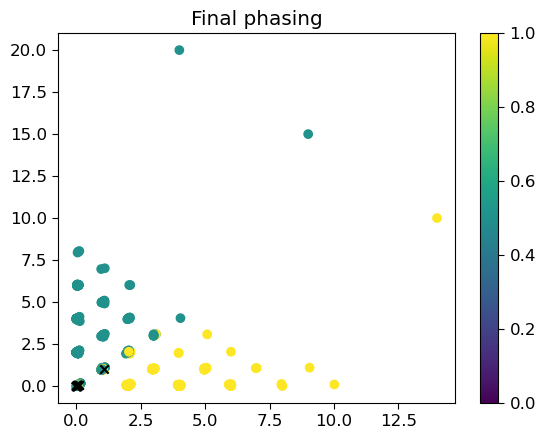

In [4]:
oldphase1, oldphase2, phased1, phased2 = return_dict['initial_phase_res']
phase_df = return_dict['phase_df']
phased1 = phase_df['final_step_phase1'].values
phased2 = phase_df['final_step_phase2'].values

plt.scatter(oldphase1, oldphase2, c=1 + phased1.astype(int) + 2 * phased2.astype(int))
indices = phase_df.index[phase_df['allele1'] == 'N/A']
plt.scatter(oldphase1[indices], oldphase2[indices], c = 'black', marker = 'x')
plt.title('Final phasing')
plt.colorbar()
#     plt.xlim((-25, 200))
#     plt.ylim((-25, 200))
plt.show()

In [24]:
quilt_phase = pd.read_csv('/well/band/users/rbx225/recyclable_files/hla/1KG_phased_' + gene + '.tsv', sep = '\t')

phase_df = return_dict['phase_df']
phased_indices = phase_df.index[(phase_df['final_step_phase1'] | phase_df['final_step_phase2'])]
print('Number of unphased samples:', len(phase_df) - len(phased_indices))

df1 = phase_df.loc[phased_indices,:]
df2 = quilt_phase.loc[phased_indices,:]

matched_haps = df1['final_step_phase1'] == df2['phase1_final']
percet_matched_haps = (matched_haps.sum() / len(df1)) * 100
print(f'Percentage agreed with QUILT phasing for {gene}: ', percet_matched_haps, '%')

Number of unphased samples: 13
Percentage agreed with QUILT phasing for DRB1:  97.4559686888454 %


In [13]:
# For GAMCC
gene = 'A'
ipd_gen_file_dir = '/well/band/users/rbx225/recyclable_files/hla_reference_files/alignments/'
hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')
samples_to_remove = []

gamcc_hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv', unique_two_field = False)
gamcc_hla = gamcc_hla[['SampleID', 'Locus', 'Two field1', 'Two field2']].reset_index(drop = True)

colnames = ['Sample ID'] + [label for g in HLA_GENES for label in [f'HLA-{g} 1', f'HLA-{g} 2']]
hlatypes = pd.DataFrame(columns = colnames)
for s in gamcc_hla['SampleID'].unique():
    tmp = gamcc_hla[gamcc_hla['SampleID'] == s]
    row = [s] + tmp[['Two field1', 'Two field2']].values.ravel().tolist()
    hlatypes.loc[len(hlatypes)] = row

reference_allele_file = '/well/band/users/rbx225/recyclable_files/hla/b38_reference_alleles.tsv'
reference_allele_ary = np.array(lcwgsus.read_tsv_as_lst(reference_allele_file))
phased_vcf = "/well/band/users/rbx225/GAMCC/results/imputation/vcfs/malariaGen_v1_b38/quilt.chr6.vcf.gz"

subset_vcf_samples = lcwgsus.read_tsv_as_lst('/well/band/users/rbx225/GAMCC/data/sample_tsvs/fv_gm_names.tsv')
subset_vcf_samples = ','.join(subset_vcf_samples)

sample_linker = pd.read_csv('/well/band/users/rbx225/GAMCC/' + SAMPLE_LINKER_FILE)
sample_linker = {k:v for k, v in zip(sample_linker['Sample_Name'], sample_linker['Chip_Name'])}

return_dict = phase_hla_on_haplotypes(gene = gene, 
                            ipd_gen_file_dir = ipd_gen_file_dir, 
                            hla_gene_information = hla_gene_information, 
                            hlatypes = hlatypes,
                            phased_vcf = phased_vcf, 
                            reference_allele_ary = reference_allele_ary, 
                            strict_snp_filter = False,
                            read_from_QUILT = True, 
                            subset_vcf_samples = subset_vcf_samples,
                            sample_linker = sample_linker)

hlatypes = return_dict['hlatypes']

individual = 'GAM951638'
ix = hlatypes.index[hlatypes['Sample ID'] == individual][0]
display_indices = np.arange(10)
html = 'GAMCC-DRB1.html'

res = visualise_phase(gene, ix, hlatypes, return_dict, both_het = True)
compare_phase(display_indices, res, save_html = True, save_name = html)

plot_first_step_phase(return_dict)
plot_last_step_phase(return_dict)

>>> Phasing commences
>>> Parameters for this run:
>>> - gene: A
>>> - db directory: /well/band/users/rbx225/recyclable_files/hla_reference_files/alignments/
>>> - vcf file: /well/band/users/rbx225/GAMCC/results/imputation/vcfs/malariaGen_v1_b38/quilt.chr6.vcf.gz
>>> - strict filtering on SNPs: False
>>> - read from QUILT: True
>>> - subset samples: True


IndexError: index 2549 is out of bounds for axis 0 with size 5

---

In [20]:
# Checking with QUILT phasing
retained_samples = hlatypes['Sample ID'].tolist()
trios = pd.read_csv('/well/band/users/rbx225/recyclable_files/ref_panels/oneKG/integrated_call_samples_v3.20200731.ALL.ped', sep = '\t')
trios = trios[trios['Individual ID'].isin(retained_samples)]
trios = trios[(trios['Paternal ID'].isin(retained_samples)) | (trios['Maternal ID'].isin(retained_samples))]
trios = trios[['Individual ID', 'Paternal ID', 'Maternal ID']]

trios['allele1'] = 'N/A'
trios['allele2'] = 'N/A'
undetermined_trios = []

trios = trios.apply(func = phase_trios, args = (gene, hlatypes), axis = 1)

kgp_samples_idx = hlatypes.index[hlatypes['Sample ID'].isin(trios['Individual ID'])].to_numpy()
kgp_samples_phase = phased1[kgp_samples_idx]

phased_res = pd.DataFrame({'Sample ID': trios['Individual ID'].tolist(), 'allele1': reftypes1[kgp_samples_idx], 'allele2': reftypes2[kgp_samples_idx]})

for i in range(len(phased_res)):
    if kgp_samples_phase[i] == False:
        tmp = phased_res.iloc[i, 1]
        phased_res.iloc[i, 1] = phased_res.iloc[i, 2]
        phased_res.iloc[i, 2] = tmp

res = pd.merge(phased_res, trios[['Individual ID', 'allele1', 'allele2']], left_on = 'Sample ID', right_on = 'Individual ID', suffixes = ('_pred', '_true'))
res = res.drop(columns = 'Individual ID')
res

NameError: name 'phase_trios' is not defined

In [5]:
# Checking 1KG trios

full_start = return_dict['b38_start']
full_end = return_dict['b38_end']
hlatypes = return_dict['hlatypes']

retained_samples = hlatypes['Sample ID'].tolist()
trios = pd.read_csv('/well/band/users/rbx225/recyclable_files/ref_panels/oneKG/integrated_call_samples_v3.20200731.ALL.ped', sep = '\t')
trios = trios[trios['Individual ID'].isin(retained_samples)]
trios = trios[(trios['Paternal ID'].isin(retained_samples)) & (trios['Maternal ID'].isin(retained_samples))]
trios = trios[['Individual ID', 'Paternal ID', 'Maternal ID']]

trio_samples_all = trios.values.ravel().tolist()

df = read_vcf(
        full_start - 5000, 
        full_end + 5000, 
        phased_vcf, 
        hlatypes, 
        False, 
        ','.join(trio_samples_all), 
        None)

df = df[(df['ref'].str.len() == 1) & (df['alt'].str.len() == 1)]

df_up = df[df['pos'] < full_start]
df_down = df[df['pos'] > full_end]

phase_df = return_dict['phase_df']
phase_df = phase_df[phase_df['Sample'].isin(trio_samples_all)]

trio_haps = {}

for child in trios['Individual ID']:
    mat_id, pat_id = trios[trios['Individual ID'] == child][['Maternal ID', 'Paternal ID']].values[0]
    
    child_alleles = phase_df[phase_df['Sample'] == child][['allele1', 'allele2']].values[0]
    mat_alleles = phase_df[phase_df['Sample'] == mat_id][['allele1', 'allele2']].values[0]
    pat_alleles = phase_df[phase_df['Sample'] == pat_id][['allele1', 'allele2']].values[0]
    
    df_up_child = df_up[['pos', 'ref', 'alt'] + [child, mat_id, pat_id]]
    df_up_child = df_up_child[~df_up_child[child].str.contains(r'\.')]
    df_up_child['pat'] = df_up_child[child].str.split('|').str.get(0)
    df_up_child['mat'] = df_up_child[child].str.split('|').str.get(1)
    het_sites = (df_up_child['mat'] != df_up_child['pat'])
    
    upstream_idx = het_sites[het_sites].index[-1]
    ref, alt, mat, pat = df_up_child.loc[upstream_idx, ['ref', 'alt', 'mat', 'pat']]
    
    mat_genotypes = df_up_child.loc[upstream_idx, mat_id].split('|')
    pat_genotypes = df_up_child.loc[upstream_idx, pat_id].split('|')
    
    if mat_genotypes[0] == '0':
        mat_hap1 = ref + '-' + mat_alleles[0] + '-'
    elif mat_genotypes[0] == '1':
        mat_hap1 = alt + '-' + mat_alleles[0] + '-'
    else:
        mat_hap1 = 'N' + '-' + mat_alleles[0] + '-'
        
    if mat_genotypes[1] == '0':
        mat_hap2 = ref + '-' + mat_alleles[1] + '-'
    elif mat_genotypes[1] == '1':
        mat_hap2 = alt + '-' + mat_alleles[1] + '-'
    else:
        mat_hap2 = 'N' + '-' + mat_alleles[1] + '-'
    
    if pat_genotypes[0] == '0':
        pat_hap1 = ref + '-' + pat_alleles[0] + '-'
    elif pat_genotypes[0] == '1':
        pat_hap1 = alt + '-' + pat_alleles[0] + '-'
    else:
        pat_hap1 = 'N' + '-' + pat_alleles[0] + '-'
        
    if pat_genotypes[1] == '0':
        pat_hap2 = ref + '-' + pat_alleles[1] + '-'
    elif pat_genotypes[1] == '1':
        pat_hap2 = alt + '-' + pat_alleles[1] + '-'
    else:
        pat_hap2 = 'N' + '-' + pat_alleles[1] + '-'
    
    if pat == '0':
        child_hap1 = ref + '-' + child_alleles[0] + '-'
        child_hap2 = alt + '-' + child_alleles[1] + '-'
    elif pat == '1':
        child_hap1 = alt + '-' + child_alleles[0] + '-'
        child_hap2 = ref + '-' + child_alleles[1] + '-'
    else:
        child_hap1 = 'N' + '-' + child_alleles[0] + '-'
        child_hap2 = 'N' + '-' + child_alleles[1] + '-'
    
    df_down_child = df_down[['pos', 'ref', 'alt'] + [child, mat_id, pat_id]]
    df_down_child = df_down_child[~df_down_child[child].str.contains(r'\.')]
    df_down_child['pat'] = df_down_child[child].str.split('|').str.get(0)
    df_down_child['mat'] = df_down_child[child].str.split('|').str.get(1)
    het_sites = (df_down_child['mat'] != df_down_child['pat'])
    downstream_idx = het_sites[het_sites].index[0]
    ref, alt, mat, pat = df_down_child.loc[downstream_idx, ['ref', 'alt', 'mat', 'pat']]
    
    mat_genotypes = df_down_child.loc[downstream_idx, mat_id].split('|')
    pat_genotypes = df_down_child.loc[downstream_idx, pat_id].split('|')
    
    if mat_genotypes[0] == '0':
        mat_hap1 = mat_hap1 + ref
    elif mat_genotypes[0] == '1':
        mat_hap1 = mat_hap1 + alt
    else:
        mat_hap1 = mat_hap1 + 'N'
        
    if mat_genotypes[1] == '0':
        mat_hap2 = mat_hap2 + ref
    elif mat_genotypes[1] == '1':
        mat_hap2 = mat_hap2 + alt
    else:
        mat_hap2 = mat_hap2 + 'N'
    
    if pat_genotypes[0] == '0':
        pat_hap1 = pat_hap1 + ref
    elif pat_genotypes[0] == '1':
        pat_hap1 = pat_hap1 + alt
    else:
        pat_hap1 = pat_hap1 + 'N'
        
    if pat_genotypes[1] == '0':
        pat_hap2 = pat_hap2 + ref
    elif pat_genotypes[1] == '1':
        pat_hap2 = pat_hap2 + alt
    else:
        pat_hap2 = pat_hap2 + 'N'
    
    if pat == '0':
        child_hap1 = child_hap1 + ref
        child_hap2 = child_hap2 + alt
    elif pat == '1':
        child_hap1 = child_hap1 + alt
        child_hap2 = child_hap2 + ref
    else:
        break
    
    trio_haps[child] = [child_hap1, child_hap2, pat_hap1, pat_hap2, mat_hap1, mat_hap2]
    
for v in trio_haps.values():
    print(v)
    
# So after checking the phased vcfs it is always correct that (for these trios) the phasing designation is pat|mat
# Given this information we don't need to check for het sites
# However if we do check there are some alleles that don't perfectly match the snp haplotypes..

['A-14:54-T', 'G-09:01-G', 'G-08:03-T', 'A-14:54-G', 'A-14:04-T', 'G-09:01-G']
['A-11:04-T', 'G-03:01-G', 'A-11:04-T', 'G-12:01-G', 'A-03:01-G', 'G-14:54-T']
['G-12:02-C', 'A-12:02-A', 'G-12:02-C', 'G-10:01-C', 'G-12:02-C', 'A-08:03-A']
['A-03:01-T', 'G-01:01-A', 'A-03:01-T', 'G-15:01-A', 'G-01:01-A', 'G-01:01-A']
['A-12:01-T', 'G-16:02-A', 'A-13:01-T', 'G-12:01-T', 'G-16:02-A', 'A-11:01-T']
['G-07:01-G', 'A-03:01-A', 'G-07:01-G', 'G-15:01-A', 'G-16:02-A', 'A-03:01-A']
['G-01:02-T', 'A-14:06-G', 'G-01:02-T', 'G-04:11-T', 'G-04:07-T', 'A-14:06-G']


In [ ]:
# RETAIN THIS!
# gamcc_hla = pd.read_csv('/well/band/users/rbx225/GAMCC/data/hla_direct_sequencing/HLA_direct_sequencing_all.csv')
# gamcc_hla = gamcc_hla[['SampleID', 'Locus', 'Included Alleles']]
# for s in gamcc_hla['SampleID'].unique():
#     tmps = gamcc_hla[gamcc_hla['SampleID'] == s]
#     for l in HLA_GENES:
#         tmpl = tmps[tmps['Locus'] == l]
#         repeat = 2 - tmpl.shape[0]
#         if repeat == 2:
#             gamcc_hla.loc[len(gamcc_hla)] = [s, l, np.nan]
#             gamcc_hla.loc[len(gamcc_hla)] = [s, l, np.nan]
#         if repeat == 1:
#             gamcc_hla.loc[len(gamcc_hla)] = [s, l, tmpl.iloc[0,2]]
                
# gamcc_hla = gamcc_hla[gamcc_hla['Locus'] == gene]
# gamcc_hla = gamcc_hla[['SampleID', 'Included Alleles']]

# gamcc_hla = pd.merge(gamcc_hla[::2], gamcc_hla[1::2], on = 'SampleID')
# gamcc_hla.columns = ['Sample ID', 'HLA-DRB1 1', 'HLA-DRB1 2']
# gamcc_hla

# x = gamcc_hla.iloc[0, 1]
# indices = []
# db_alleles = db.index.to_numpy()

# for a in x.split('/'):
#     old_a = a
#     while (gene + '*' + a) not in db.index and ':' in a:
#         a = a.rsplit(':', 1)[0]
#     if ':' in a:
#         indices.append(np.where(db_alleles == gene + '*' + a)[0][0])

# x = db.iloc[np.array(indices), :]